In [8]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.models import Sequential, Model
import random

import pandas_datareader as pdr
import yfinance as yf
import sklearn as sklearn


yf.pdr_override()


In [9]:
companyList = ['Apple', 'Google', 'Microsoft', 'Amazon', 'Netflix', 'Meta']
tickerList = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NFLX', 'META']
dfList = []


end = dt.now()
start = dt(end.year - 5, end.month, end.day)

for comp, ticker in zip(companyList, tickerList):
    dfList.append(yf.download(ticker, start, end))

dfList[0].head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-24,48.112499,48.415001,48.012501,48.250000,46.111328,74791600
2018-07-25,48.264999,48.712502,48.107498,48.705002,46.546165,66839600
2018-07-26,48.652500,48.990002,48.402500,48.552502,46.400429,76304000
2018-07-27,48.747501,48.797501,47.525002,47.744999,45.628716,96096000
2018-07-30,47.974998,48.049999,47.267502,47.477501,45.373070,84118000


In [10]:
dfList[0].info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-07-24 to 2023-07-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1257 non-null   float64
 1   High       1257 non-null   float64
 2   Low        1257 non-null   float64
 3   Close      1257 non-null   float64
 4   Adj Close  1257 non-null   float64
 5   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.7 KB


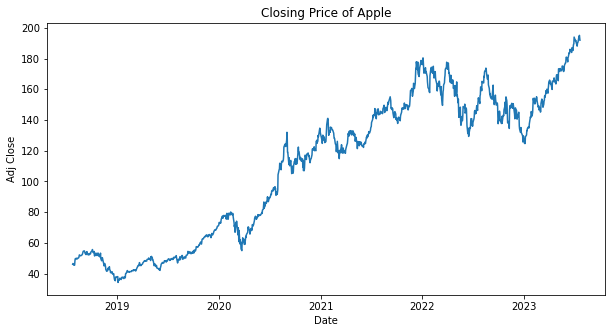

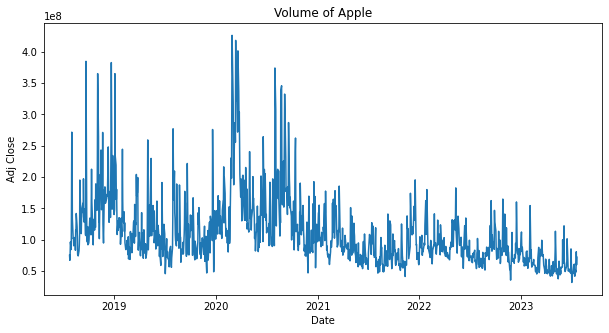

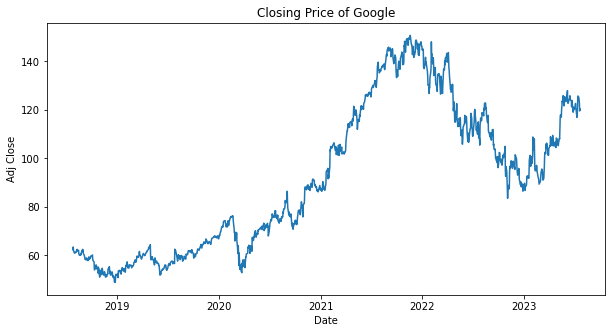

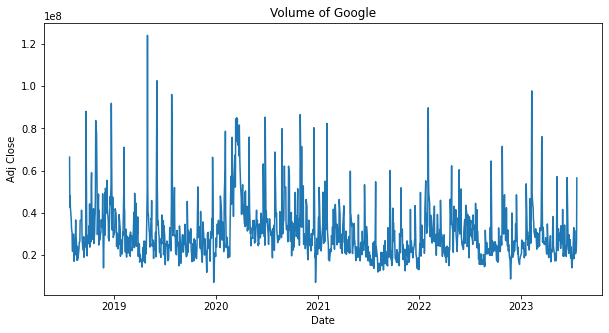

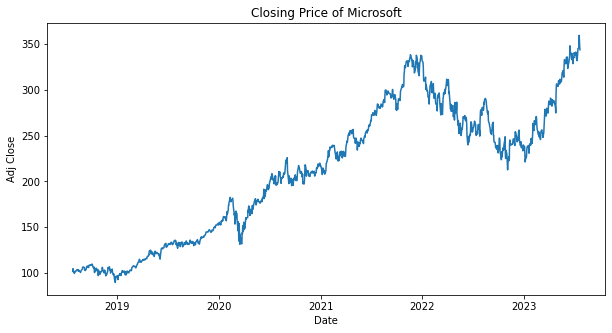

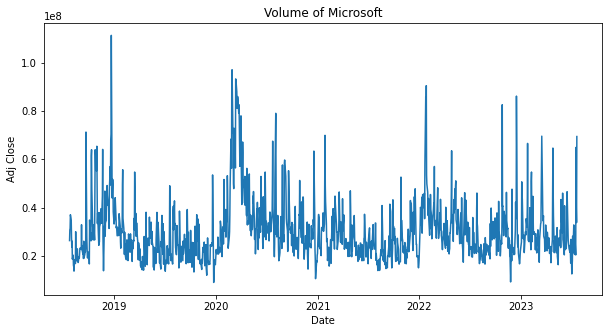

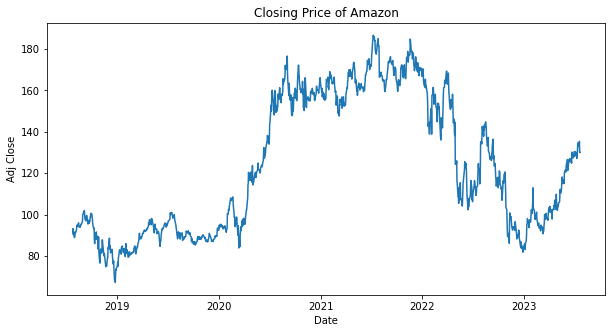

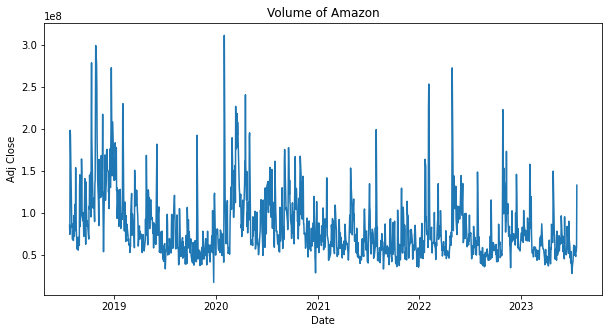

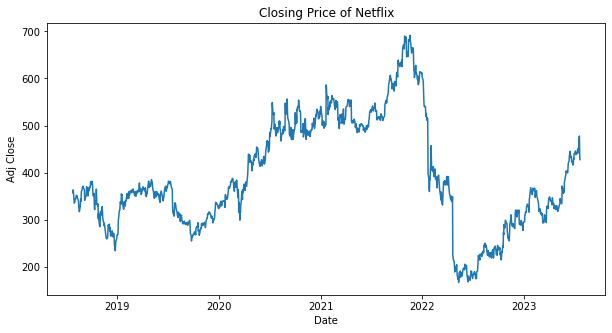

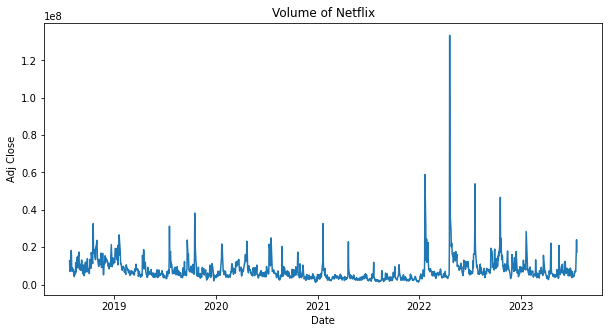

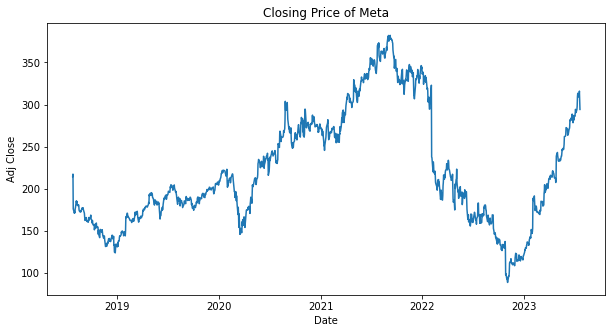

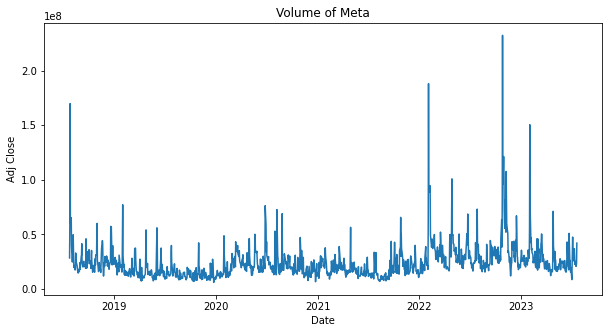

In [11]:

for ticker, comp in zip(companyList, dfList):
        plt.figure(figsize=(10, 5))
        sns.lineplot(comp, x='Date', y='Adj Close')
        

        plt.ylabel('Adj Close')
        plt.title(f"Closing Price of {ticker}")
        plt.show()
        plt.figure(figsize=(10, 5))
        plt.ylabel('Adj Close')
        plt.title(f"Volume of {ticker}")
        sns.lineplot(comp, x='Date', y='Volume')

        
        plt.show()


In [12]:
for comp, df in zip(companyList, dfList):
    st = '{} correlation btw Close and Volume: {}'.format(comp, df['Adj Close'].corr(df['Volume']))
    print(st)

Apple correlation btw Close and Volume: -0.43794202495278217
Google correlation btw Close and Volume: -0.2650426098963528
Microsoft correlation btw Close and Volume: -0.07364248450299281
Amazon correlation btw Close and Volume: -0.2126088390533868
Netflix correlation btw Close and Volume: -0.36491769103708965
Meta correlation btw Close and Volume: -0.2424338416944994


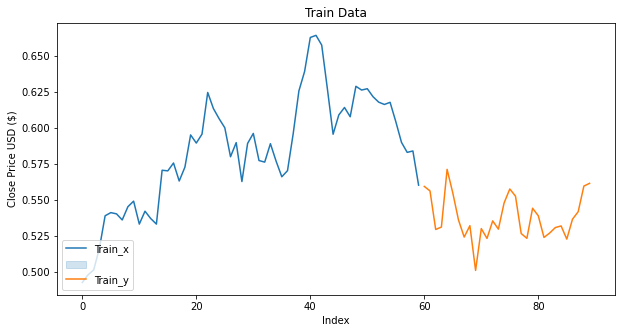

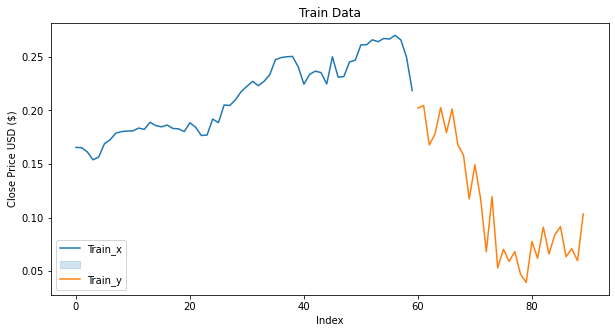

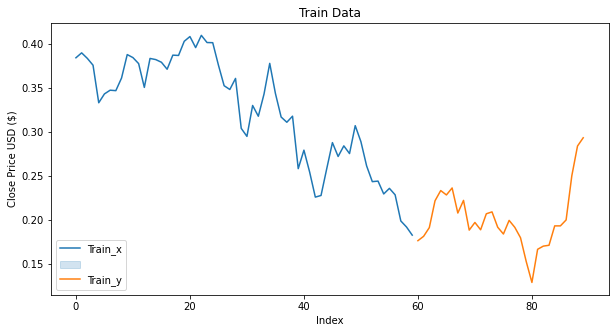

2023-07-24 02:58:01.263840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-24 02:58:01.265643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-24 02:58:01.266882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6252/6252 [==============================] - 157s 25ms/step - loss: 0.0075


In [13]:
train_period = 60
forcast_period = 30
train_split = 0.9



scaledDataList = []
scalarList = []

model = Sequential()
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(forcast_period))

model.compile(optimizer='adam', loss='mean_squared_error')

x_train, y_train = [], []

for df in dfList:
    closeScalar = MinMaxScaler(feature_range=(0,1))
    volScalar = MinMaxScaler(feature_range=(0,1))
    
    trainLen = int(len(df.index) * train_split)
    
    scaledClose = pd.DataFrame(closeScalar.fit_transform(df[['Adj Close']]), columns=['Adj Close'])
    scaledVol = pd.DataFrame(volScalar.fit_transform(df[['Volume']]), columns=['Volume'])
    
    scaledData = pd.concat([scaledClose, scaledVol], axis=1)
    

    x_trainData = scaledData.iloc[:trainLen].to_numpy()
    y_trainData = scaledData['Adj Close'].iloc[:trainLen].to_numpy()
    
    scaledDataList.append(scaledData)
    
    

    for i in range(train_period, trainLen):
        if i + forcast_period > len(x_trainData):
            break
        x = x_trainData[i-train_period : i]
        y = y_trainData[i:i+forcast_period]
        x_train.append(x)
        y_train.append(y)

    
    scalarList.append([closeScalar, volScalar])


factor = 1000
count = 0
for i in range(len(x_train)):
    if random.randrange(0, factor) >= 1 or count >= 3:
        continue
    sns.set_palette("tab10")
    plt.figure(figsize=(10, 5))
    plt.title('Train Data')

    x_train_vis = pd.DataFrame(x_train[i], columns=['Close', 'Vol'])
    y_train_vis = pd.DataFrame(y_train[i], columns=['Close'])
    y_train_vis['newIndex'] = y_train_vis.index + train_period
    y_train_vis = y_train_vis.set_index('newIndex')


        
    sns.lineplot(data=x_train_vis['Close'])
    sns.lineplot(data=y_train_vis['Close'])

    plt.xlabel('Index')
    plt.ylabel('Close Price USD ($)')

    plt.legend(['Train_x', '', 'Train_y'], loc='lower left')
    plt.show()
    count += 1

x_train, y_train = np.array(x_train), np.array(y_train)

model.fit(x_train, y_train, batch_size=1, epochs=1)



2023-07-24 03:00:38.263623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-24 03:00:38.265443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-24 03:00:38.268699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 35ms/step


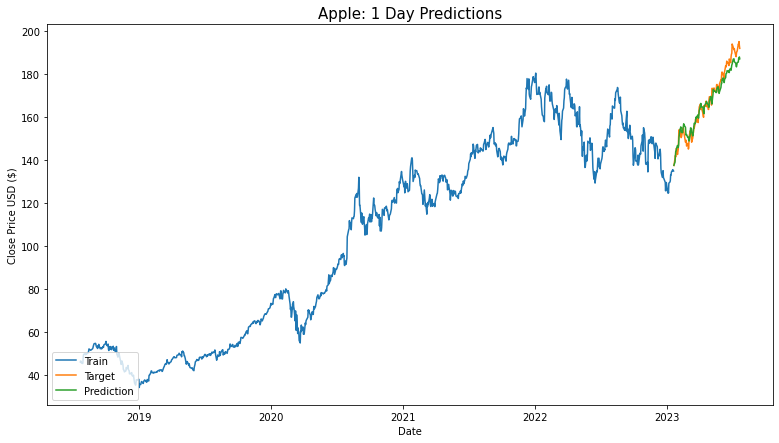

4/4 [==============================] - 0s 32ms/step


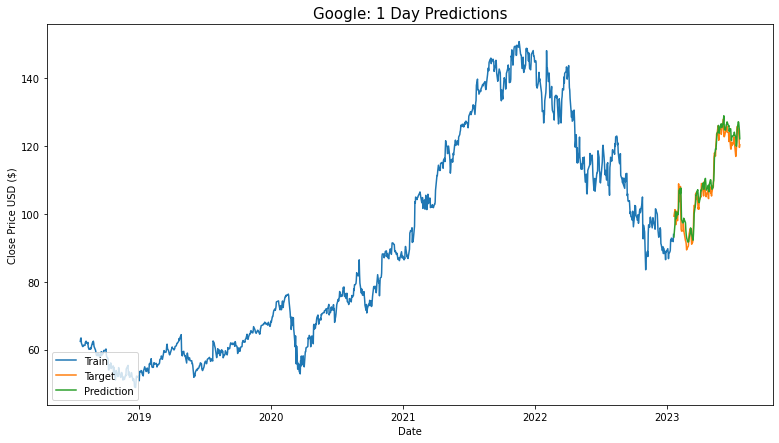

4/4 [==============================] - 0s 28ms/step


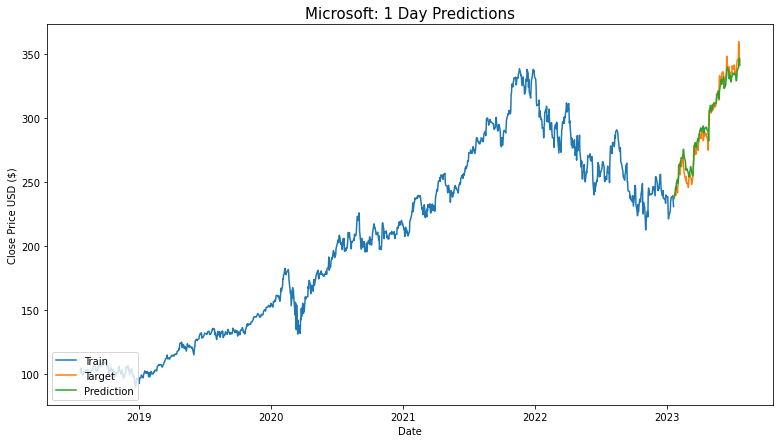

4/4 [==============================] - 0s 32ms/step


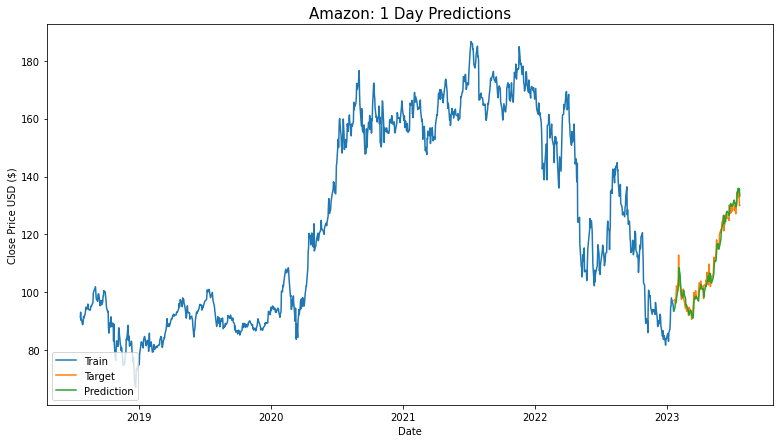

4/4 [==============================] - 0s 31ms/step


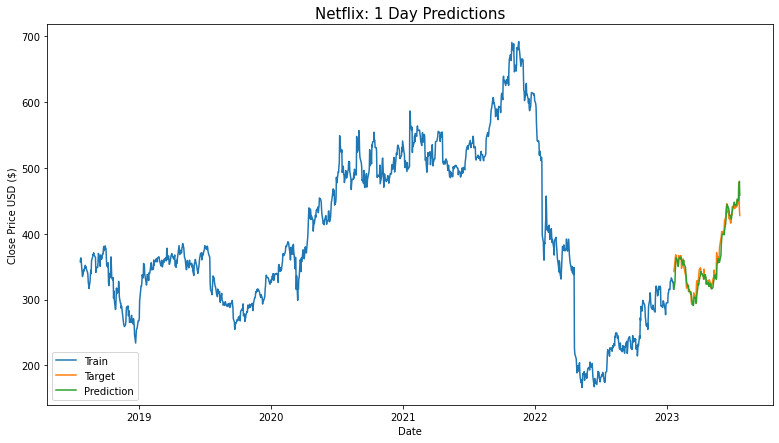

4/4 [==============================] - 0s 38ms/step


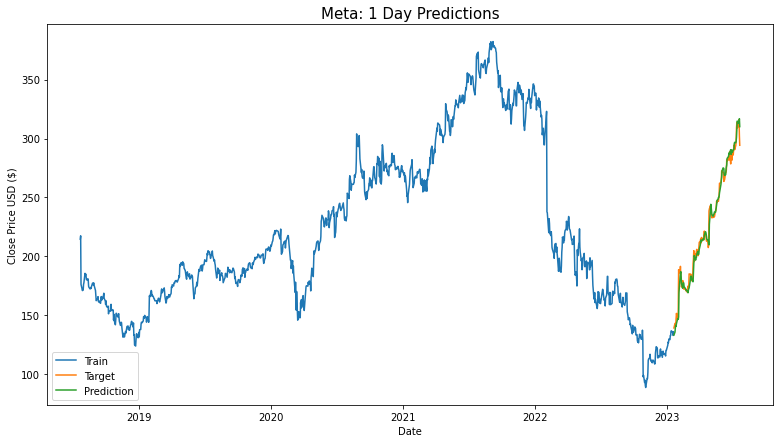

In [14]:
sns.set_palette("tab10")
predictionsDfList = []
for i, df in enumerate(dfList):
    scaledData = scaledDataList[i].to_numpy()
    
    trainLen = int(len(df.index) * train_split)
    
    x_test = []
    y_test = []
    
    for j in range(trainLen, len(scaledData)):
        x_test.append(scaledData[j-train_period:j, :])
        y_test.append(scaledData[j])
        

    x_test = np.array(x_test)

    predictions = model.predict(x_test)
    
    scaledPredictions = scalarList[i][0].inverse_transform(predictions)
    cols = []
    for j in range(1, 1 + forcast_period):
        cols.append('{} day'.format(j))
    scaledPredictionsDf = pd.DataFrame(scaledPredictions, columns=cols)
    
    predictionsDfList.append(scaledPredictionsDf)
    
    
    pd.set_option('mode.chained_assignment', None)
    
    disp_forcast = '1 day'
    oneDayForcast = scaledPredictionsDf[disp_forcast]
        
    train = df.iloc[:trainLen]
    valid = df.iloc[trainLen:]
    
    valid[disp_forcast] = oneDayForcast.to_numpy()
    
    plt.figure(figsize=(13, 7))
    plt.title( str(companyList[i]) + ': 1 Day Predictions', fontsize=15)
    
    plt.plot(train.index, train['Adj Close'])
    plt.plot(valid.index, valid['Adj Close'])
    plt.plot(valid.index, valid[disp_forcast])

    
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Close Price USD ($)', fontsize=10)

    plt.legend(['Train', 'Target', 'Prediction'], loc='lower left')
    plt.show()
    

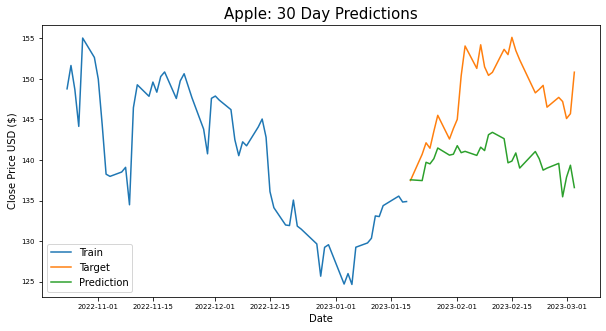

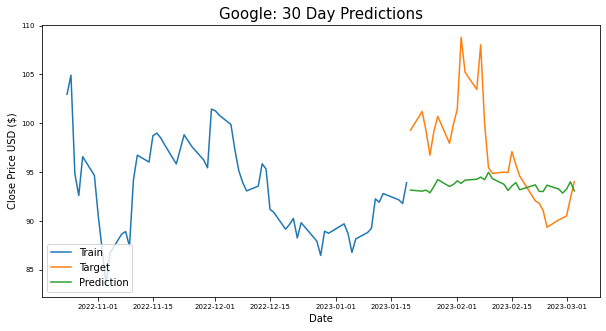

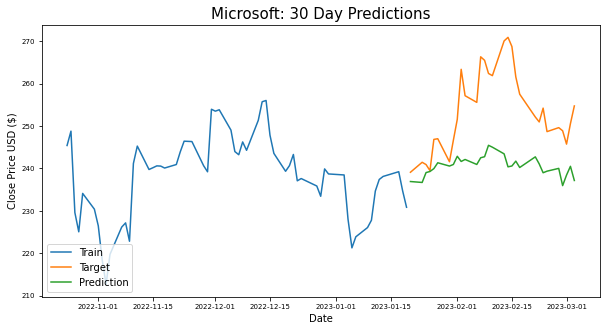

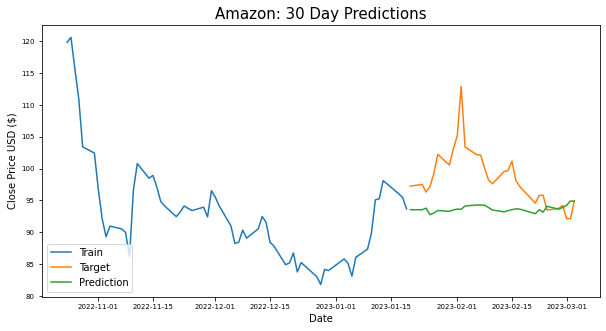

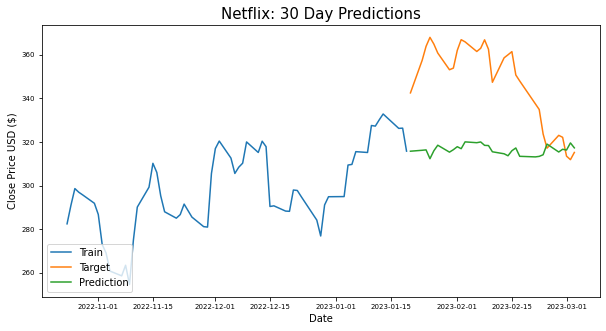

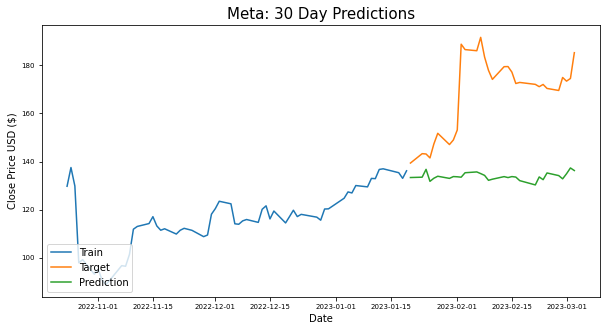

In [16]:
for i, df in enumerate(dfList):
    scaledPredictions = predictionsDfList[i].to_numpy()
    disp_forcast = '1 day'
    
    train = df.iloc[trainLen - train_period:trainLen]
    valid = df.iloc[trainLen: trainLen + forcast_period]
    
    valid[disp_forcast] = scaledPredictions[0]
    # Visualize the data
    plt.figure(figsize=(10, 5))
    plt.title( str(companyList[i]) + ': 30 Day Predictions', fontsize=15)
    
    matplotlib.rc('xtick', labelsize=7) 
    matplotlib.rc('ytick', labelsize=7)
    
    sns.set_palette("tab10")
    
    plt.plot(train.index, train['Adj Close'])
    plt.plot(valid.index, valid['Adj Close'])
    plt.plot(valid.index, valid[disp_forcast])

    
 

    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Close Price USD ($)', fontsize=10)

    plt.legend(['Train', 'Target', 'Prediction'], loc='lower left')
    plt.show()